## Reinforcement Learning Project

In [48]:
import numpy as np
from typing import Dict, Tuple, List
import csv 
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import os 
from PIL import Image 
from torch.utils.data import Dataset, DataLoader, SequentialSampler, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import json
from collections import Counter 
from tqdm import tqdm
from torch.nn.functional import softmax
import time
import concurrent.futures
from threading import Lock
from torch.utils.tensorboard import SummaryWriter

### Define RL Env 

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create tensorboard
summary = SummaryWriter("./Tensorboards/", purge_step=0)

In [50]:
#CNN Model
class FineTunedAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedAlexNet, self).__init__()
        
        alexnet = models.alexnet(pretrained=True)

        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.fc(x)
        return x

num_classes = 5
cnn_model = FineTunedAlexNet(num_classes=num_classes).to(device)
cnn_model.load_state_dict(torch.load("cnn_model.pth", map_location=torch.device(device)))
cnn_model.eval()

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTunedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bia

In [51]:
# RL Environment 
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class Env: 
    _condition_symptom_probabilities: Dict[str, Dict[str, float]] # conditions with symptoms and their probabilities
    _actions: list[str] # symptoms
    _init_state: np.array
    _current_state: np.array
    _img: torch.tensor
    _condition: str # the condition which the simulated patient has
    _symptoms_of_condition: Dict[str, float] # symptoms of the condition which the simulated patient has
    _supported_conditions: list[str]
    _cnn_model: FineTunedAlexNet
    _num_asked_symptoms: int
    _punishment_cost: float
    _episode_length: int
    
    def __init__(self,
                 img: torch.tensor, 
                 condition: str,
                 cnn_model: FineTunedAlexNet,
                 visual_prior_train: torch.tensor = None
                ) -> None:  
        self._supported_conditions= ["pneumonia", "pneumothorax", "lung cancer", "pleural effusion", "cardiomyopathy"]
        self._img = img
        self._cnn_model = cnn_model 
        self._num_asked_symptoms = 0
        self._episode_length = 10
        self._punishment_cost = 0.4
        #if(condition is None): 
        #    condition = random.sample(self._supported_conditions,1)[0]
        self._condition = condition

        # init condition_symptom_probabilities from HealthKnowledgeGraph.csv
        self._condition_symptom_probabilities = self.load_condition_symptom_probabilities()
        # init condition_symptom_probabilities from slake knowledge graph 
        #self._condition_symptom_probabilities= dict()
        #with open('Slake1.0/KG/en_disease.csv', newline='') as csvfile:
        #    reader = csv.reader(csvfile, delimiter='#')
        #    reader.__next__() # skip header 
        #    for row in reader:
        #        if(row[1]!="symptom"):
        #            continue
        #        if(row[0] not in self._supported_conditions):
        #            continue
        #        self._condition_symptom_probabilities[row[0]] = dict()
        #        n_symptoms=len(row[2].split(','))
        #        uniform_prob = 1/(2**n_symptoms)
        #        for symptom in row[2].split(','):
        #            #assign uniform conditional probability because no conditional probability are available 
        #            self._condition_symptom_probabilities[row[0]][symptom.strip()] = uniform_prob

        # check if condition is valid
        if(self._condition not in self._condition_symptom_probabilities.keys()):
            raise ValueError('Unknow Condition: ' + condition + '. Please choose one of the following: ' + str(self._condition_symptom_probabilities.keys()))
        
        # init symptoms_of_condition for easier access
        self._symptoms_of_condition = self._condition_symptom_probabilities[self._condition]

        # init actions
        self._actions = list()
        for condition in self._condition_symptom_probabilities.keys(): 
            for symptom in list(self._condition_symptom_probabilities[condition]):
                if symptom not in self._actions:
                    self._actions.append(symptom) 


        
        #compute visual prior
        if(visual_prior_train is not None):
            visual_prior=visual_prior_train
        else:
            logits = self._cnn_model(img[None,:].to(device))[0]
            logits = logits.cpu()
            #sort logits to the same order as in self._condition_symptom_probabilities. CNN_model output: Lung Cancer: idx 0, Pneumothorax: idx 1, Pneumonia: idx 2, Effusion: idx 3, Cardiomegaly: idx 4 
            #logit_indicies = {
            #    "lung cancer": 0,
            #    "pneumothorax": 1, 
            #    "pneumonia": 2, 
            #    "pleural effusion": 3, 
            #    "cardiomyopathy": 4
            #}  
            logit_indicies = {
            "lung cancer": 0,
            "pneumonia": 1, 
            "pneumothorax": 2,
            "pleural effusion": 3,
            "cardiomyopathy": 4,
            }
            condition_logit_idx = [logit_indicies[c] for c in self._condition_symptom_probabilities.keys()]
            visual_prior = softmax(torch.tensor([logits[idx] for idx in condition_logit_idx])) 
            #visual_prior = np.ones(shape=(len(self._condition_symptom_probabilities.keys()))) #TODO: replace with cnn output 
            # init init_state = vector with cnn output (probabilities per condition) and history of asked symptoms (0=not asked, 1=symptom is present, -1=symptom is not present)
        self._init_state = np.concatenate((visual_prior,np.zeros((len(self._actions))),np.zeros(1)), axis=0)
        self._current_state = self._init_state.copy()

    def load_condition_symptom_probabilities(self) -> Dict[str, Dict[str, float]]:
        condition_symptom_probabilities = dict()

        with open('HealthKnowledgeGraph.csv', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            # skip header
            header = next(reader)  
            for row in reader:
                # to make it case insensitive
                condition = row[0].lower() 
                
                # if condition is in the supported conditions list then add the symptoms to the list
                if condition not in self._supported_conditions:
                    continue

                symptoms_and_probs = row[1].split(',')
                symptom_probabilities = dict()
                for symptom_prob in symptoms_and_probs:
                    # example for symptom_prob: pain (0.318)
                    symptom, prob = map(str.strip, symptom_prob.split('('))
                    # to remove the last parentheses ')'
                    prob = float(prob[:-1])  
                    symptom_probabilities[symptom] = prob
                condition_symptom_probabilities[condition] = symptom_probabilities 
        return condition_symptom_probabilities

    def final_state(self) -> bool:
        if(self._num_asked_symptoms >= self._episode_length):
            return True
        else:
            return False
    
    def posterior_of_condition(self, condition: str, useAddition=False) -> float: 
        #TODO: What is the correct likelihood calculation? If we use multiplication as in P(x,y)=P(x)*P(y), the likelihood gets smaller 
        #and nothing prevents the model from asking symptoms which are not related to the condition.
        if(useAddition):
            likelihood=0
        else:
            likelihood=1
        for idx, symptom in enumerate(self._actions):
            patient_answer = self._current_state[idx+len(self._condition_symptom_probabilities.keys())]
            #if (patient_answer==1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*= 0
            #elif (patient_answer==-1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*=1
            if (symptom not in self._condition_symptom_probabilities[condition].keys()):
                #TODO: Do we have to punish the model if a symptom is positive and is not related to the condition?
                continue 
            elif patient_answer==1:
                if(useAddition):
                    likelihood+=self._condition_symptom_probabilities[condition][symptom]
                else:
                    likelihood*=self._condition_symptom_probabilities[condition][symptom]
            elif patient_answer==-1:
                if(useAddition):
                    likelihood+=(1-self._condition_symptom_probabilities[condition][symptom]) 
                else:
                    likelihood*=(1-self._condition_symptom_probabilities[condition][symptom]) 

        prior = self._current_state[list(self._condition_symptom_probabilities.keys()).index(condition)]
        if(useAddition):
            result = likelihood+prior
        else:
            result = likelihood*prior
        return result
    
    def reward(self) -> float:
        #TODO: Is it a problem when the reward gets smaller and smaller?
        punishment=self._num_asked_symptoms*self._punishment_cost
        return self.posterior_of_condition(self._condition, useAddition=True)-punishment
    
    def has_symptom(self, symptom: str) -> bool:
        if symptom not in self._symptoms_of_condition:
            return False
        else:
            phi = np.random.uniform()
            return phi <= self._symptoms_of_condition[symptom]

    def step(self, action_idx: int) -> Transition:
        
        if(self.final_state()):
            return Transition(self._current_state, action_idx, None, 0)
        self._num_asked_symptoms+=1
        
        action = self._actions[action_idx]
        old_state = self._current_state.copy()
        self._current_state[len(self._condition_symptom_probabilities.keys()) + action_idx] = 1 if self.has_symptom(action) else -1
        self._current_state[-1]=self._num_asked_symptoms
        

        # only give reward if it's a symptom of the condition
        #if(action in self._symptoms_of_condition):
        #    reward = self.reward()
        #else:
        #    reward = 0 
        return Transition(old_state, action_idx, self._current_state.copy(), self.reward())
    
    def reset(self) -> np.array:
        self._current_state = self._init_state.copy()
        return self._current_state.copy()
myEnv=Env([], 'pneumonia', cnn_model, np.zeros(num_classes))

In [52]:
summary.add_scalar("With Punishments", True, 0)
summary.add_scalar("With Reward Addition", True, 0)

### Prepare dataset

In [53]:
class DataProcessor:
    def __init__(self, folder_path, disease_list):
        self.folder_path = folder_path
        self.disease_list = disease_list
        self.folders_with_diseases_labels = {}
        self.folder_name_with_diseases = []
        self.label_counts = None
        
    def read_data(self):
        for root, dirs, files in os.walk(os.path.join(self.folder_path, 'imgs')):
            for folder_name in dirs:
                folder_path = os.path.join(root, folder_name)
                
                detection_file_path = os.path.join(folder_path, 'detection.json')
                with open(detection_file_path, 'r') as detection_file:
                    detection_data = json.load(detection_file)

                    disease_labels = [label.lower() for item in detection_data for label in item.keys() if label in self.disease_list]
                    
                    for idx, label in enumerate(disease_labels):
                        if label == "effusion":
                            disease_labels[idx] = "pleural effusion" 
                        elif label == "cardiomegaly":
                            disease_labels[idx] = "cardiomyopathy"
                             
                    disease_labels = set(disease_labels) 
                    
                    # merge labels for images with multiple labels
                    if disease_labels:
                        merged_label = '-'.join(sorted(disease_labels))
                        self.folders_with_diseases_labels[folder_name] = merged_label
                        self.folder_name_with_diseases.append(folder_name)

    def delete_folders(self):
        # frequency of each merged label
        self.label_counts = Counter(self.folders_with_diseases_labels.values())

        # delete folders with label counts <= 3
        folders_to_delete = [folder_name for folder_name, label in self.folders_with_diseases_labels.items() if self.label_counts[label] <= 3]

        for folder_name in folders_to_delete:
            del self.folders_with_diseases_labels[folder_name]
            self.folder_name_with_diseases.remove(folder_name)
            
    def get_training_data(self):
        training_data = []
        for folder_name, label in self.folders_with_diseases_labels.items():
            folder_path = os.path.join(self.folder_path, 'imgs', folder_name)
            image_path = os.path.join(folder_path, 'source.jpg') 
            img = Image.open(image_path).convert('RGB')
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            img = transform(img)

            logits = cnn_model(img[None,:].to(device))[0]
            logits = logits.cpu()
            #sort logits to the same order as in self._condition_symptom_probabilities. CNN_model output: Lung Cancer: idx 0, Pneumothorax: idx 1, Pneumonia: idx 2, Effusion: idx 3, Cardiomegaly: idx 4 
            #logit_indicies = {
            #    "lung cancer": 0,
            #    "pneumothorax": 1, 
            #    "pneumonia": 2, 
            #    "pleural effusion": 3, 
            #    "cardiomyopathy": 4
            #}  
            logit_indicies = {
                "cardiomyopathy": 0,
                "pneumothorax": 1,
                "pneumonia": 2, 
                "lung cancer": 3,
                "pleural effusion": 4, 
            }
            condition_logit_idx = [logit_indicies[c] for c in myEnv._condition_symptom_probabilities.keys()]
            visual_prior = softmax(torch.tensor([logits[idx] for idx in condition_logit_idx]))
            
            training_data.append((img, label, visual_prior))
        return training_data


folder_path = 'Slake1.0'
disease_list = ['Pneumothorax', 'Pneumonia', 'Effusion', 'Lung Cancer', "Cardiomegaly"]
data_processor = DataProcessor(folder_path, disease_list)
data_processor.read_data()
data_processor.delete_folders()
data = data_processor.get_training_data()

/tmp/ipykernel_17199/644418724.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  visual_prior = softmax(torch.tensor([logits[idx] for idx in condition_logit_idx]))


In [54]:
data_labels=[x[1] for x in data]
SUPPORTED_CONDITIONS = set(data_labels) 
if(num_classes!=len(SUPPORTED_CONDITIONS)):
    raise ValueError("num_classes is wrongly initialized")

In [55]:
#split training-test set
training_data, validation_data = train_test_split(data, test_size=0.2, random_state=42, shuffle = True, stratify=np.array(data_labels))

train_labels = [x[1] for x in training_data]
train_label_counts = dict(Counter(train_labels))
train_weight_samples = [1/train_label_counts[x] for x in train_labels]

In [56]:
train_sampler = WeightedRandomSampler(train_weight_samples, num_samples=len(train_labels), replacement=True)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=1)

val_sampler = SequentialSampler(validation_data)
val_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=1)

### Prepare training environment

In [57]:
# Experience Replay for RL
class ReplayMemory():
    def __init__(self, capacity):
        self.memory=deque([], maxlen=capacity)
    def push(self, transition):
        self.memory.append(transition)
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [58]:
# RL model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128, dtype=torch.double)
        self.layer2 = nn.Linear(128, 128, dtype=torch.double)
        self.layer3 = nn.Linear(128, n_actions, dtype=torch.double)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [59]:
#helper function to calculcate eps_decay
def eps_decay_cal(EPS_DECAY_2, num_epoch):
    i_decay_2=0
    epsilon_2=EPS_START
    for _ in range(num_epoch):
        if epsilon_2 > EPS_END:
            epsilon_2 = EPS_START * math.exp(-i_decay_2/EPS_DECAY_2)
            i_decay_2+=1 
    return epsilon_2

In [60]:
#eps_decay_cal(1700, 1000)

In [61]:
# BATCH_SIZE is the number of transitions sampled form the replay buffer
#GAMMA is the discount factor as mentioned in the previous section
#SIZE is the number of transitions sampled from the replay buffer
#EPS START is the starting value of epsilon
#EPS DECAY controls the rate of exposential decay of epsilon, higher means a slower decay
#EPS END is the final value of epsilon
#TAU is the update rate of the target network 
#LR the learning rate of the Adams optimizar
BATCH_SIZE = 128
GAMMA = 0.9
summary.add_scalar("GAMMA", GAMMA, 0)
EPS_START = 0.9
EPS_END = 0.1 
summary.add_scalar("EPS_END", EPS_END, 0)
EPS_DECAY = 200#2000 #with 2000 epsilon is after 6000 steps at 0.05
summary.add_scalar("EPS_DECAY", EPS_DECAY, 0)
TAU = 0.005
summary.add_scalar("TAU", TAU, 0)
LR = 1e-5
summary.add_scalar("LR", LR, 0)

n_actions = len(myEnv._actions)
n_observations = len(myEnv._current_state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0 

In [62]:
def optimize_model(losses, gradient_norms, it):
    policy_net.train()
    if len(memory) < BATCH_SIZE: 
        return
    transitions = memory.sample(BATCH_SIZE) 
    #converts batch_array of Transitions to Transition of batch_arrays
    batch = Transition(*zip(*transitions))

    #non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    #non_final_next_states = torch.stack([torch.tensor(s) for s in batch.next_state if s is not None])
    #s[-1] is number of asked symptoms 
    non_final_mask = torch.tensor(tuple(map(lambda s: s[-1] < myEnv._episode_length, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([torch.tensor(s) for s in batch.next_state if s[-1] < myEnv._episode_length])
    non_final_next_states = non_final_next_states.to(device) 
    
    state_batch = torch.tensor(batch.state).to(device)
    action_batch = torch.tensor(batch.action).to(device)
    reward_batch = torch.tensor(batch.reward).to(device)

    pred=policy_net(state_batch)
    state_action_values = pred[torch.arange(pred.shape[0]), action_batch]

    next_state_values = torch.zeros(BATCH_SIZE, device=device, dtype=torch.double)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    #TODO: state_action_values grow infinitely
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    #print("state_action_values: ", state_action_values)
    #print("action_batch: ", action_batch)
    #print("reward batch: ", reward_batch)
    #print("state batch[0]: ", state_batch[0]) 

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    losses.append((loss.detach()).cpu())
    

    parameters = [p for p in policy_net.parameters() if p.grad is not None and p.requires_grad]
    if len(parameters) == 0:
        total_norm = 0.0
    else: 
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).cpu() for p in parameters]), 2.0).item()
    gradient_norms.append(total_norm)

    if((it % 100)==0):
        summary.add_scalar("training loss", loss.cpu().item(), it)
        summary.add_scalar("gradient norm", total_norm, it)
        
    
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(policy_net.parameters(),100)
    optimizer.step()

In [63]:
def select_action(myEnv, state, epsilon):
    randnum = np.random.rand(1) 
    if randnum < epsilon:
        action_idx = np.random.randint(len(myEnv._actions))
        #print("random")
    else:  
        with torch.no_grad():
            action_idx = np.argmax(policy_net(torch.tensor(state).to(device)).cpu()).item()
            #print("state: ", state)
            #print("action_idx: ", action_idx)
            #print("policy_net: ", policy_net(torch.tensor(state).to(device)))
            #print("non random")
            #print("network: ", policy_net(torch.tensor(state).to(device)).cpu())
    
    return action_idx

In [64]:
def topKAccuracy(k=3):
    selected_actions=set()
    policy_net.eval()
    epsilon_val = 0
    N_samples=0
    N_correct_samples=0
    N_TP_condition = dict()
    N_FP_condition = dict()
    for batch in val_dataloader:
        N_samples+=1
        condition = batch[1][0]
        img = batch[0][0]  
        visual_prior = batch[2][0]
        myEnv=Env(img, condition, cnn_model, visual_prior)
        state = myEnv.reset()
        # ask patient 10 symptoms
        for _ in range(len_episode):
            action_idx = select_action(myEnv, state, epsilon_val) 
            transition = myEnv.step(action_idx)
            state = transition.next_state
            if(action_idx not in selected_actions):
                selected_actions.add(action_idx)
        #calculate posterior for every conditions
        posterior_of_conditions = [] 
        for cond in myEnv._supported_conditions:
            posterior = myEnv.posterior_of_condition(cond, useAddition=False)
            #set posterior to 0 if no symptom is related to the condition and therefore the likelihood stays
            #TODO: Delete when cnn is integrated
            if(posterior==1):
                posterior=0
            posterior_of_conditions.append((posterior, cond))
        #sort posteriors by value
        posterior_of_conditions.sort(key=lambda x: x[0])
        #get rank of posterior of correct condition
        rank = 1+next(i for i, val in enumerate(posterior_of_conditions)
                                  if val[1] == condition)
        if(condition not in N_TP_condition.keys()):
             N_TP_condition[condition]=0
        if(condition not in N_FP_condition.keys()):
             N_FP_condition[condition]=0
        if(rank <= k):
            N_TP_condition[condition]+=1
        else:
            N_FP_condition[condition]+=1 
        N_TP=np.sum(list(N_TP_condition.values())) 
        N_FP=np.sum(list(N_FP_condition.values()))
        acc= N_TP / (N_TP+N_FP)
        conf_matrix=dict()  
        for cond in N_TP_condition.keys():
            N_TP=N_TP_condition[cond]
            N_FP=N_FP_condition[cond]
            conf_matrix[cond]=N_TP / (N_TP+N_FP)
    return acc, conf_matrix, selected_actions

In [65]:
def training_episode(img: torch.tensor, condition: str, epsilon: float, it: int, visual_prior: torch.tensor = None):
    myEnv=Env(img, condition, cnn_model, visual_prior)
    state = myEnv.reset()
    #print("new condition: ", condition) 
    total_reward=0
    for _ in range(len_episode):  
        action_idx = select_action(myEnv, state, epsilon)
        #print(action_idx)
        transition = myEnv.step(action_idx)
        #last_reward=transition.reward
        total_reward+=transition.reward
        state = transition.next_state 
        #print(transition) 
        rewards.append(transition.reward)
        memory.push(transition) 
        summary.add_scalar("Reward", transition.reward, it)
    if((it % 10)==0):
        summary.add_scalar("Final Reward", transition.reward, it) 
        summary.add_scalar("Total Reward", total_reward, it) 
        summary.add_scalar("epsilon", epsilon, it) 
    for _ in range(len_episode):  
        optimize_model(losses, gradient_norms, it)

        #Soft update of target network weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict) 
    #total_reward_per_episode.append(last_reward) 
        

### Start with training

In [66]:
num_epochs = 1#1300#1600#2500
summary.add_scalar("num_epochs", num_epochs, 0)
len_episode = 10
summary.add_scalar("len_episode", len_episode, 0)
i_decay=1
epsilon = EPS_START
losses=[]
gradient_norms=[]
rewards=[]
epsilons=[]
total_reward_per_episode=[]
num_selected_actions=[]

In [67]:
it=0
best_acc=0
for _ in tqdm(range(num_epochs)):
    it+=1
    if epsilon > EPS_END:
        epsilon = EPS_START * math.exp(-i_decay/EPS_DECAY)
        i_decay+=1 
    epsilons.append(epsilon)
    for batch in train_dataloader:
        condition = batch[1][0]
        img = batch[0][0] 
        visual_prior = batch[2][0]  
        training_episode(img, condition, epsilon, it, visual_prior)  
        #pool.map(training_episode, (img, condition, epsilon)) 
    acc, conf_matrix, selected_actions = topKAccuracy(k=1)
    summary.add_scalar("topKAccuracy", acc, it)
    summary.add_scalar("num_selected_actions", len(selected_actions), it)
    num_selected_actions.append(len(selected_actions))
    if(best_acc<acc):
        best_acc=acc
        torch.save(policy_net.state_dict(), "best_RL_model.pt")
print("complete") 

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_17199/4063029874.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  non_final_mask = torch.tensor(tuple(map(lambda s: s[-1] < myEnv._episode_length, batch.next_state)), device=device, dtype=torch.bool)
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.74s/it]

complete


In [68]:
#load trained model from ubelix
#policy_net.load_state_dict(torch.load("RL_model.pth", map_location=torch.device(device)))

In [69]:
torch.save(policy_net.state_dict(), 'RL_model.pth')

In [70]:
# helper function
def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)))
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

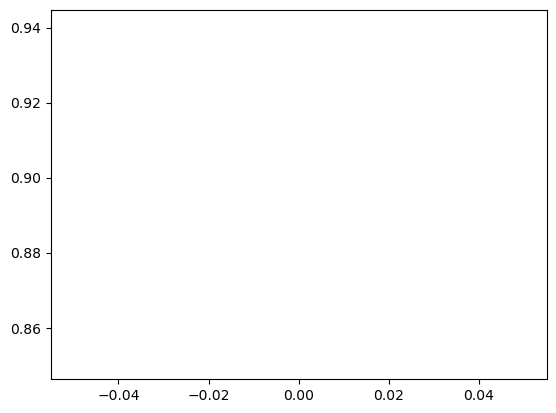

In [71]:
plt.plot(epsilons)
#plt.savefig('epsilons.png')

Text(0.5, 1.0, 'losses')

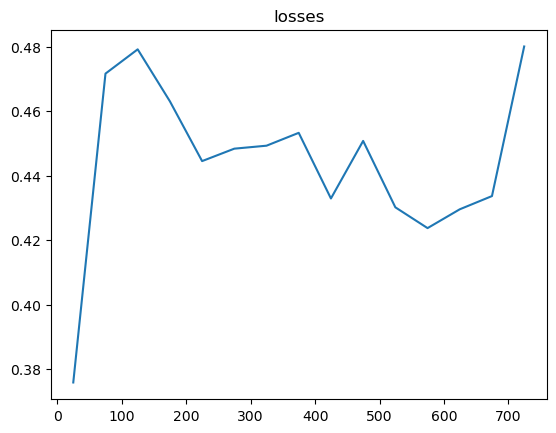

In [72]:
t,y = averagewindow(losses, d=50)
plt.plot(t,y)
plt.title("losses")
#plt.savefig('losses.png')

Text(0.5, 1.0, 'gradient norms')

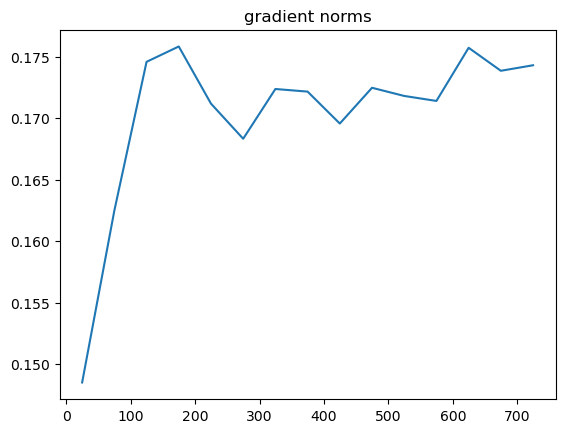

In [73]:
t,y = averagewindow(gradient_norms, d=50)
plt.plot(t,y)
plt.title("gradient norms")
#plt.savefig('gradient norms.png')

Text(0.5, 1.0, 'Rewards')

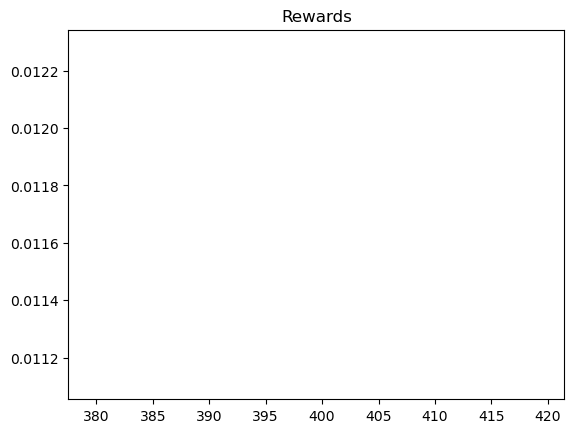

In [74]:
t,y = averagewindow(rewards, d=800)
plt.plot(t,y)
plt.title("Rewards")
#plt.savefig('rewards.png')

Text(0.5, 1.0, 'Number of selected actions during evaluation')

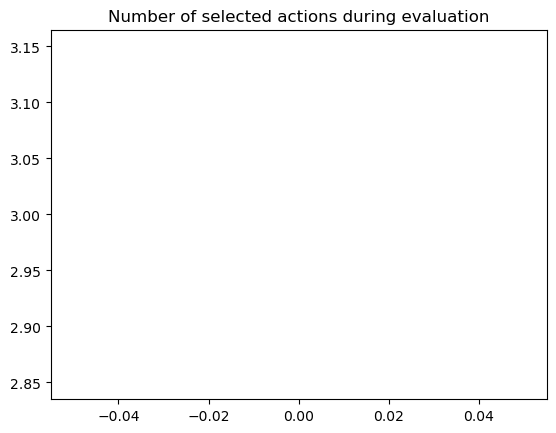

In [75]:
t,y = averagewindow(num_selected_actions, d=1)
plt.plot(t,y)
plt.title("Number of selected actions during evaluation")
#plt.savefig('total reward per episode.png')

### Evaluation

In [76]:
acc, conf_matrix, selected_actions = topKAccuracy(k=1)
print("acc: ", acc) #Random model would have 0.6
print("conf_matrix: ", conf_matrix)
print("num selected actions: ", len(selected_actions))

acc:  0.30434782608695654
conf_matrix:  {'pneumothorax': 0.0, 'cardiomyopathy': 1.0, 'lung cancer': 0.0, 'pneumonia': 0.0, 'pleural effusion': 0.0}
num selected actions:  3


### Test cases

In [77]:
#policy_net.eval()

In [78]:
"""
#Testing simulated patient answers
myTestEnv=Env(np.array([]), 'pneumothorax', cnn_model)
print("Symptoms for Pertussis:")
print(myTestEnv._condition_symptom_probabilities['pneumothorax'])
print("Expected uniform conditional proabability: 1\(", 2**len(myTestEnv._condition_symptom_probabilities['pneumothorax'].keys()), ")")
n=0
prob=0
for i in range(10000):
    n+=1
    if myTestEnv.has_symptom('pain'):
        prob+=1 
print("\n Probability of spastic cough after 10000 samples: " + str(prob/n))
"""

'\n#Testing simulated patient answers\nmyTestEnv=Env(np.array([]), \'pneumothorax\', cnn_model)\nprint("Symptoms for Pertussis:")\nprint(myTestEnv._condition_symptom_probabilities[\'pneumothorax\'])\nprint("Expected uniform conditional proabability: 1\\(", 2**len(myTestEnv._condition_symptom_probabilities[\'pneumothorax\'].keys()), ")")\nn=0\nprob=0\nfor i in range(10000):\n    n+=1\n    if myTestEnv.has_symptom(\'pain\'):\n        prob+=1 \nprint("\n Probability of spastic cough after 10000 samples: " + str(prob/n))\n'

In [79]:
"""
#Testing reward
myTestEnv=Env(np.array([]), 'pneumothorax', cnn_model)
print("prior of condition:")
print(myTestEnv._current_state[list(myTestEnv._condition_symptom_probabilities.keys()).index("pneumothorax")])

myTestEnv.step(myTestEnv._actions.index('coughing'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('coughing')] 
print("Probability of coughing: " + str(myTestEnv._condition_symptom_probabilities['pneumothorax']['coughing']))
print("Result patient asking if he has coughing: " + str(result))

myTestEnv.step(myTestEnv._actions.index('pain'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('pain')] 
print("Probability of pain: " + str(myTestEnv._condition_symptom_probabilities['pneumothorax']['pain']))
print("Result patient asking if he has pain: " + str(result))

myTestEnv.step(myTestEnv._actions.index('shortness of breath'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('shortness of breath')] 
print("Probability of shortness of breath: " + str(myTestEnv._condition_symptom_probabilities['pneumothorax']['shortness of breath']))
print("Result patient asking if he has shortness of breath: " + str(result))

print("Reward: " + str(myTestEnv.reward()))
"""

'\n#Testing reward\nmyTestEnv=Env(np.array([]), \'pneumothorax\', cnn_model)\nprint("prior of condition:")\nprint(myTestEnv._current_state[list(myTestEnv._condition_symptom_probabilities.keys()).index("pneumothorax")])\n\nmyTestEnv.step(myTestEnv._actions.index(\'coughing\'))\nresult=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index(\'coughing\')] \nprint("Probability of coughing: " + str(myTestEnv._condition_symptom_probabilities[\'pneumothorax\'][\'coughing\']))\nprint("Result patient asking if he has coughing: " + str(result))\n\nmyTestEnv.step(myTestEnv._actions.index(\'pain\'))\nresult=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index(\'pain\')] \nprint("Probability of pain: " + str(myTestEnv._condition_symptom_probabilities[\'pneumothorax\'][\'pain\']))\nprint("Result patient asking if he has pain: " + str(result))\n\nmyTestEnv.step(myTestEnv._actions.inde

#### Testing Suite for Q Learning

In [80]:
"""
#pick a sample
for batch in train_dataloader:
    condition = batch[1][0]
    img = batch[0][0] 
    visual_prior = batch[2][0]
    break
print("Condition: ", condition)
print("Visual Prior: ", visual_prior)
print("Visual Prior of condition: ", visual_prior[list(myEnv._condition_symptom_probabilities.keys()).index(condition)])
"""

'\n#pick a sample\nfor batch in train_dataloader:\n    condition = batch[1][0]\n    img = batch[0][0] \n    visual_prior = batch[2][0]\n    break\nprint("Condition: ", condition)\nprint("Visual Prior: ", visual_prior)\nprint("Visual Prior of condition: ", visual_prior[list(myEnv._condition_symptom_probabilities.keys()).index(condition)])\n'

In [81]:
"""
#Init Environement with sample
myEnv=Env(img, condition, cnn_model, visual_prior)
state = myEnv.reset()
"""

'\n#Init Environement with sample\nmyEnv=Env(img, condition, cnn_model, visual_prior)\nstate = myEnv.reset()\n'

In [82]:
"""
#go step by step and check the numbers
print("current state: ", state)
#print("state-action values: ", policy_net(torch.tensor(state).to(device)))
action_idx = np.argmax(policy_net(torch.tensor(state)).detach().cpu()).item()
state_action_value = policy_net(torch.tensor(state).to(device))[action_idx]
print("Best state-action value: ", state_action_value.item())
print("Choosen action: ", action_idx, " name: ", myEnv._actions[action_idx])
transition = myEnv.step(action_idx)
print("Next state: ", transition.next_state)
print("Reward next state: ", transition.reward)
reward=transition.reward
#print("state-action values next state: ", target_net(torch.tensor(transition.next_state).to(device)))
best_state_action_next_state=target_net(torch.tensor(transition.next_state[None,:])).max(1)[0]
print("Best state-action value of next state: ", best_state_action_next_state.item())
expected_state_value=((best_state_action_next_state) * GAMMA) + reward
print("Expected state-action value from current state: ", expected_state_value.item())
print("loss: ", criterion(expected_state_value, state_action_value).item())
state=transition.next_state
"""

'\n#go step by step and check the numbers\nprint("current state: ", state)\n#print("state-action values: ", policy_net(torch.tensor(state).to(device)))\naction_idx = np.argmax(policy_net(torch.tensor(state)).detach().cpu()).item()\nstate_action_value = policy_net(torch.tensor(state).to(device))[action_idx]\nprint("Best state-action value: ", state_action_value.item())\nprint("Choosen action: ", action_idx, " name: ", myEnv._actions[action_idx])\ntransition = myEnv.step(action_idx)\nprint("Next state: ", transition.next_state)\nprint("Reward next state: ", transition.reward)\nreward=transition.reward\n#print("state-action values next state: ", target_net(torch.tensor(transition.next_state).to(device)))\nbest_state_action_next_state=target_net(torch.tensor(transition.next_state[None,:])).max(1)[0]\nprint("Best state-action value of next state: ", best_state_action_next_state.item())\nexpected_state_value=((best_state_action_next_state) * GAMMA) + reward\nprint("Expected state-action valu

#### Testing accuracy of CNN

In [83]:
"""
indicies = {
            "lung cancer": 0,
            "pneumonia": 1, 
            "pneumothorax": 2,
            "pleural effusion": 3,
            "cardiomyopathy": 4,
        }
N=0
TP=0 
for batch in train_dataloader:
    condition = batch[1][0]
    img = batch[0][0]
    
    #if(condition!="pleural effusion"):
    #    continue
    logits=cnn_model(img[None,:].to(device))
    probs = softmax(logits.detach())
    #print(probs)
    #myEnv=Env(img, condition, cnn_model)
    #state = myEnv.reset() 
    N+=1 
    if(np.argmax(probs) == indicies[condition]):
        TP+=1
print("number of samples: ", N)
print("number of TP: ", TP)
print("accuracy: ", TP/N)
"""

/tmp/ipykernel_17199/4047132900.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = softmax(logits.detach())


number of samples:  88
number of TP:  51
accuracy:  0.5795454545454546


In [84]:
#create python script for ubelix
!jupyter nbconvert --to script "RL_environment.ipynb"

[NbConvertApp] Converting notebook RL_environment.ipynb to script
[NbConvertApp] Writing 32659 bytes to RL_environment.py
